
Prepared by

*Asif Newaz*

*Lecturer, EEE, IUT*


**In this notebook, a CNN model is applied on a real-world dataset. Moreover, the effect of data augmentation is also presented here.**

The dataset is collected from Kaggle

Microsoft Cats vs Dogs dataset

https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random
from shutil import copyfile

# Data Visualization

**Data Visualization**

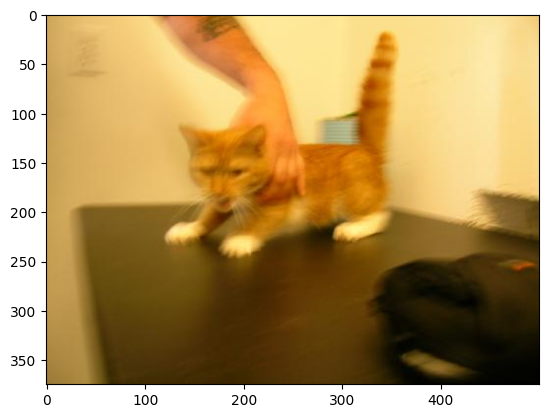

In [ ]:
path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/0.jpg'
img = tf.keras.preprocessing.image.load_img(path)
plt.imshow(img)

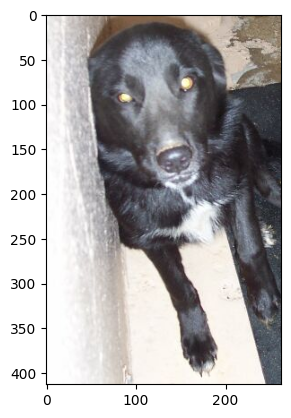

In [ ]:
path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10000.jpg'
img = tf.keras.preprocessing.image.load_img(path)
plt.imshow(img)

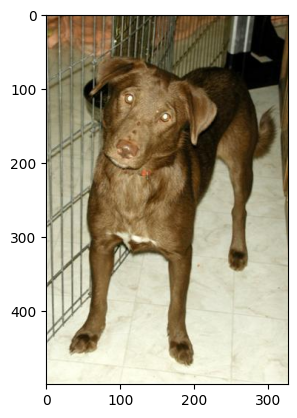

In [ ]:
path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/1.jpg'
img = tf.keras.preprocessing.image.load_img(path)
plt.imshow(img)

In [ ]:
img.size

(327, 500)

# Directory

**Fix directory**

Here, all the files are located in the same directory. We need to divide it into training and testing folds and place the images there randomly.

In [ ]:
# make working directory
! cp -R /kaggle/input/* /kaggle/working

In [ ]:
# create new directories to place images

! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/training/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/training/Dog/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/training/Cat/

! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/testing/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/testing/Dog/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/testing/Cat/

In [ ]:
# function to split the data into training and testing with eqaul cats and dogs images
# additional checking for faulty image files

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE,DESTINATION):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " has not enough pixels to represent it as an image, seems corrupted so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

#####################################################################################

DESTINATION = "/kaggle/working"

CAT_SOURCE_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Cat/"
DOG_SOURCE_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Dog/"

TRAINING_CATS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/training/Cat/"
TESTING_CATS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/testing/Cat/"

TRAINING_DOGS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/training/Dog/"
TESTING_DOGS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/testing/Dog/"

In [ ]:
split_size = .8
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size,DESTINATION)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size,DESTINATION)

666.jpg has not enough pixels to represent it as an image, seems corrupted so ignoring.
11702.jpg has not enough pixels to represent it as an image, seems corrupted so ignoring.


In [ ]:
print("Total number of training cat images: ", len(os.listdir(TRAINING_CATS_DIR)))
print("Total number of training dog images: ", len(os.listdir(TRAINING_DOGS_DIR)))

print("Total number of testing cat images: ", len(os.listdir(TESTING_CATS_DIR)))
print("Total number of testing dog images: ", len(os.listdir(TESTING_DOGS_DIR)))

Total number of training cat images:  10000
Total number of training dog images:  10000
Total number of testing cat images:  2500
Total number of testing dog images:  2500


In [ ]:
print("Total number of training images: ", len(os.listdir("/kaggle/working/microsoft-catsvsdogs-dataset/training/")))

Total number of training images:  2


In [ ]:
training_data_path = "/kaggle/working/microsoft-catsvsdogs-dataset/training/"

{'Cat': 10000, 'Dog': 10000}


In [ ]:
validation_data_path = "/kaggle/working/microsoft-catsvsdogs-dataset/testing/"

# Data Preprocessing

**Data Preparation**

We are going to use data generator for preparing or preprocessing our data. It makes the process simpler.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(training_data_path,target_size=(224,224),batch_size=128,class_mode='binary')
test_generator = test_datagen.flow_from_directory(validation_data_path,target_size=(224,224),batch_size=128,class_mode='binary')

Found 19999 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.


Original image size is (327, 500). We need to convert them to an image size we want to work with. It can be done easily with data generator. The size is reduced to (224, 224) for this model. You can work with other size images. However, large size image will increase the size of the receptive field -> increasing the number of parameters to train.

# CNN architecture

**CNN model**

In [ ]:
model_v7 = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding= 'same', activation="relu",input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), padding= 'same',  activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3), padding= 'same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), padding= 'same',  strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
]
)

In [ ]:
model_v7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                        

**Callbacks**

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

# Training

**Model Training**

In [ ]:
model_v7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_v7 = model_v7.fit(train_generator,
                          epochs=50,
                          validation_data=test_generator,
                          callbacks=early_stop)

Epoch 1/50


2024-02-16 13:55:02.698685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708091711.283881     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  8/157 [>.............................] - ETA: 52s - loss: 0.8537 - accuracy: 0.5615

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


157/157 [==============================] - 94s 496ms/step - loss: 0.5631 - accuracy: 0.7137 - val_loss: 1.0071 - val_accuracy: 0.4999
Epoch 2/50
157/157 [==============================] - 74s 471ms/step - loss: 0.4059 - accuracy: 0.8196 - val_loss: 0.8804 - val_accuracy: 0.5365
Epoch 3/50
157/157 [==============================] - 74s 468ms/step - loss: 0.3321 - accuracy: 0.8568 - val_loss: 0.6634 - val_accuracy: 0.6567
Epoch 4/50
157/157 [==============================] - 74s 470ms/step - loss: 0.2819 - accuracy: 0.8825 - val_loss: 0.3002 - val_accuracy: 0.8672
Epoch 5/50
157/157 [==============================] - 74s 468ms/step - loss: 0.2268 - accuracy: 0.9065 - val_loss: 0.2626 - val_accuracy: 0.8860
Epoch 6/50
157/157 [==============================] - 73s 466ms/step - loss: 0.1825 - accuracy: 0.9237 - val_loss: 0.3117 - val_accuracy: 0.8606
Epoch 7/50
157/157 [==============================] - 73s 465ms/step - loss: 0.1484 - accuracy: 0.9414 - val_loss: 0.2065 - val_accuracy: 0.9

In [ ]:
df_v7 = pd.DataFrame(history_v7.history)
df_v7.tail()

,loss,accuracy,val_loss,val_accuracy
8,0.105073,0.958348,0.213055,0.918384
9,0.079949,0.969998,0.219063,0.913983
10,0.064684,0.974199,0.296466,0.897780
11,0.058774,0.977799,0.322900,0.879776
12,0.047266,0.981799,0.292239,0.908782


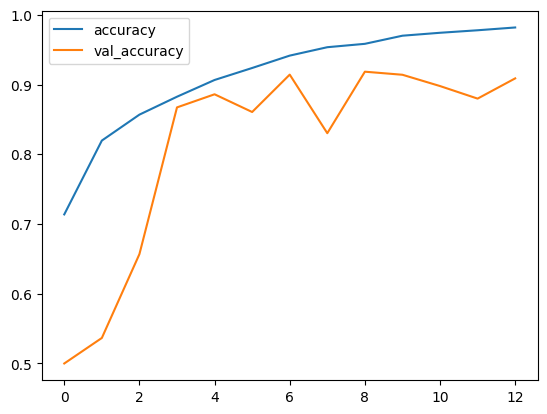

In [ ]:
df_v7[["accuracy","val_accuracy"]].plot();

The validation accuracy is around 90%. But the model is gradually overfitting.

# Data Augmentation

**Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range= 30,
                                   shear_range=.2,
                                   zoom_range=0.3,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(training_data_path,target_size=(224,224),batch_size=128,class_mode='binary')
test_generator = test_datagen.flow_from_directory(validation_data_path,target_size=(224,224),batch_size=128,class_mode='binary')

Found 19999 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.


In [ ]:
history_v7_2 = model_v7.fit(train_generator,
                          epochs=40,
                          validation_data=test_generator,
                          callbacks=early_stop)

Epoch 1/40
106/157 [===================>..........] - ETA: 1:33 - loss: 0.4809 - accuracy: 0.7967

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


157/157 [==============================] - 304s 2s/step - loss: 0.4477 - accuracy: 0.8073 - val_loss: 0.2944 - val_accuracy: 0.8716
Epoch 2/40
157/157 [==============================] - 305s 2s/step - loss: 0.3682 - accuracy: 0.8339 - val_loss: 0.5718 - val_accuracy: 0.7592
Epoch 3/40
157/157 [==============================] - 306s 2s/step - loss: 0.3213 - accuracy: 0.8604 - val_loss: 0.4575 - val_accuracy: 0.8036
Epoch 4/40
157/157 [==============================] - 305s 2s/step - loss: 0.2946 - accuracy: 0.8681 - val_loss: 0.3222 - val_accuracy: 0.8424
Epoch 5/40
157/157 [==============================] - 304s 2s/step - loss: 0.2901 - accuracy: 0.8730 - val_loss: 0.2860 - val_accuracy: 0.8838
Epoch 6/40
157/157 [==============================] - 302s 2s/step - loss: 0.2729 - accuracy: 0.8836 - val_loss: 0.6696 - val_accuracy: 0.6671
Epoch 7/40
157/157 [==============================] - 305s 2s/step - loss: 0.2578 - accuracy: 0.8884 - val_loss: 0.1938 - val_accuracy: 0.9208
Epoch 8/40

In [ ]:
df_v7_2 = pd.DataFrame(history_v7_2.history)
df_v7_2.tail()

,loss,accuracy,val_loss,val_accuracy
11,0.232617,0.900545,0.209931,0.911582
12,0.221587,0.906495,0.216553,0.906781
13,0.217621,0.910796,0.185397,0.924385
14,0.213574,0.908795,0.278343,0.879776
15,0.207704,0.910996,0.203596,0.911382


# Performance Assessment

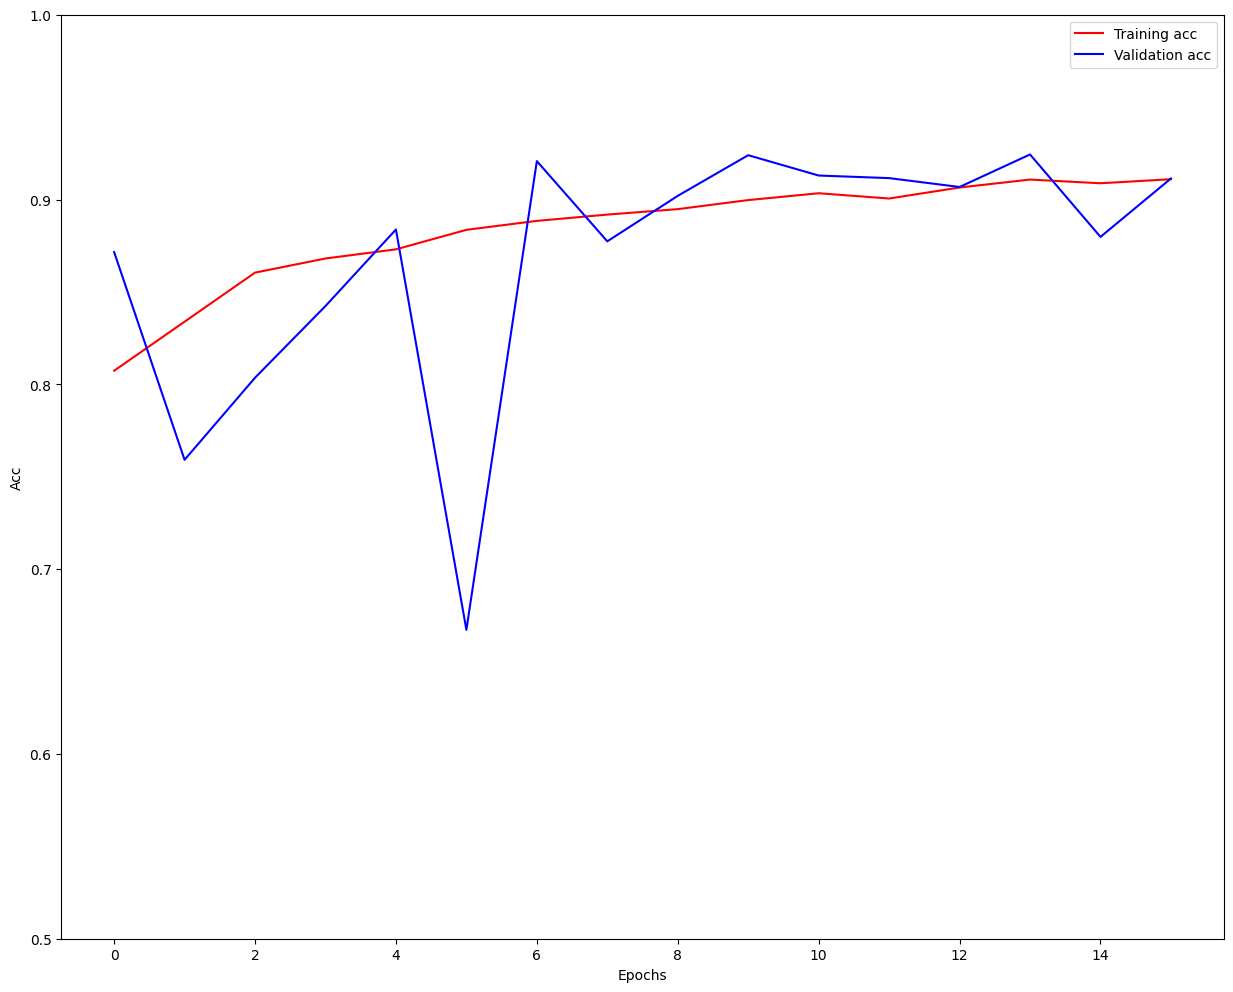

In [ ]:
#df_v7_2[["accuracy","val_accuracy"]].plot();
train_acc = df_v7_2["accuracy"]
val_acc = df_v7_2["val_accuracy"]
epochs = range(len(train_acc))

plt.figure(figsize=(15,12))
plt.ylim([0.5, 1])
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

key observations -
* training time has increased. As in each epoch, the training data is subjected to augmentation - increasing the dataset size.
* training accuracy is now on per with the validation accuracy. So overfitting has reduced.